# 6) BiLSTM 과 CRF

## 1. CRF(Conditional Random Field)
- BiLSTM과는 독자적으로 존재하는 모델 
- BiLSTM의 layer로 추가 
- 기존에 CRF 층이 존재하지 않았던 BiLSTM 모델은 활성화 함수를 지난 시점에서 개체명을 결정하지만 CRF 층을 추가할 경우 활성화 함수의 결과들이 CRF 층의 입력으로 전달됨

### BiLSTM은 입력 단어에 대한 양방향 문맥 반영
### CRF는 출력 레이블에 대한 양방향 문맥 반영

## 2. 실습 진행 전 환경 설정 및 설치

In [2]:
# CRF 사용을 위한 keras-contirb 설치
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/q9/pty21jc157l8w174dv7rhpr80000gn/T/pip-req-build-2p21xh2r
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101064 sha256=85f1640cb52cba34fe1dc6c4223061a5d47519db9fad6074abab02cb675272db
  Stored in directory: /private/var/folders/q9/pty21jc157l8w174dv7rhpr80000gn/T/pip-ephem-wheel-cache-gi13ussl/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


## 3. NER에 대한 이해와 전처리

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mac/opt/anaconda3/lib/python3.7/site-packag

In [4]:
train_set = './data/msra_train_bio.txt'
test_set = './data/msra_test_bio.txt'

In [5]:
def raw_data_preprocessing(file_name):
    tagged_sentences = []
    sentence = []
    with open(file_name,'r') as f:
        for line in f.readlines():
            if len(line) == 0 or line[0] == '\n':
                if len(sentence) > 0:
                    tagged_sentences.append(sentence)
                    sentence = []
                continue
            if line =='0\t\n':
                continue
            word, ner_tag = line.strip().split('\t') 
            sentence.append([word, ner_tag]) # 단어와 개체명 태깅만 기록
    return tagged_sentences

In [6]:
train_sents = raw_data_preprocessing(train_set)
test_sents = raw_data_preprocessing(test_set)

In [7]:
# sentence, ner_tag 분리
def separate_sent_tag(tagged_sentences):
    sentences,  ner_tags = [], []
    for tagged_sentence in tagged_sentences:
        sentence, tag_info = zip(*tagged_sentence)
        sentences.append(list(sentence))
        ner_tags.append(list(tag_info))
    return sentences, ner_tags

In [8]:
sentences, ner_tags = separate_sent_tag(train_sents)
test_sentences, test_ner_tags = separate_sent_tag(test_sents)

### train 데이터 확인

샘플의 최대 길이 : 746
샘플의 평균 길이 : 48.255911


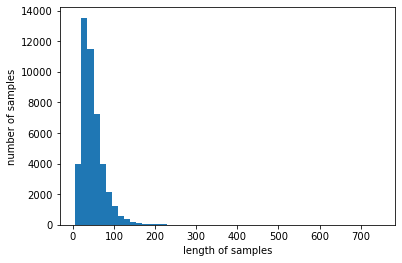

In [9]:
# show the whole data
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### test 데이터 확인

샘플의 최대 길이 : 2427
샘플의 평균 길이 : 50.145555


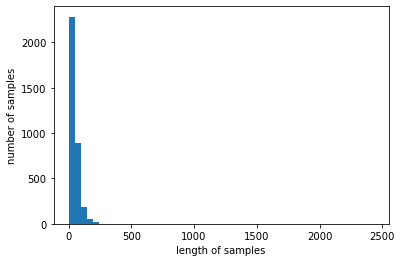

In [10]:
# show the whole data
print('샘플의 최대 길이 : %d' % max(len(l) for l in test_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, test_sentences))/len(test_sentences)))
plt.hist([len(s) for s in test_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# integer encoding using keras tokenizer
src_tokenizer = Tokenizer(oov_token = 'OOV')
src_tokenizer.fit_on_texts(sentences + test_sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags + test_ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

# perform integer encoding
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)
# perform integer encoding
X_test = src_tokenizer.texts_to_sequences(test_sentences)
y_test = tar_tokenizer.texts_to_sequences(test_ner_tags)

# create the 'index to word
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD' # 0번째 key값에 임의 할당

# padding
max_len = 200
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = pad_sequences(y_test, padding='post', maxlen=max_len)

단어 집합의 크기 : 4832
개체명 태깅 정보 집합의 크기 : 8
단어 OOV의 인덱스 : 1


In [12]:
# split the data 8 : 2 (train : test)
X_train, y_train = X_data, y_data

# one-hot encoding 
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

# cheack the dimension
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (45000, 200)
훈련 샘플 레이블의 크기 : (45000, 200, 8)
테스트 샘플 문장의 크기 : (3442, 200)
테스트 샘플 레이블의 크기 : (3442, 200, 8)


# 4. F1-score 측정 콜백 클래스




In [13]:
!pip install seqeval

In [14]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

In [15]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

## 5. BiLSTM+CRF를 이용한 NER


In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

In [17]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [18]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1, verbose = 1, callbacks=[F1score(use_char=False)])

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '



Train on 40500 samples, validate on 4500 samples
Epoch 1/10
 2720/40500 [=>............................] - ETA: 6:07 - loss: 10.2909 - crf_viterbi_accuracy: 0.7861

KeyboardInterrupt: 

In [20]:
bilstm_crf_model = load_model('./model/keras_best_model.h5', custom_objects={'CRF':CRF,
                                                  'crf_loss':crf_loss,
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [21]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = bilstm_crf_model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
实                : O       O
现                : O       O
祖                : O       O
国                : O       O
的                : O       O
完                : O       O
全                : O       O
统                : O       O
一                : O       O
，                : O       O
是                : O       O
海                : O       O
内                : O       O
外                : O       O
全                : O       O
体                : O       O
中                : B-LOC   B-LOC
华                : I-LOC   I-LOC
儿                : O       O
女                : O       O
的                : O       O
共                : O       O
同                : O       O
心                : O       O
愿                : O       O
，                : O       O
也                : O       O
是                : O       O
历                : O       O
史                : O       O
赋                : O       O
予                : O       O
我 

## 6. 실제 모델에 대해서 f1-score 구하기기

In [22]:
f1score = F1score(use_char=False)

y_predicted = bilstm_crf_model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [23]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 82.6%


In [24]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         LOC       0.87      0.83      0.85      2811
         ORG       0.77      0.73      0.75      1293
         PER       0.87      0.83      0.85      1333

   micro avg       0.85      0.81      0.83      5437
   macro avg       0.84      0.80      0.82      5437
weighted avg       0.85      0.81      0.83      5437

